In [1]:
#import DESTiler

#tiler=DESTiler.DESTiler("DES_DR1_TILE_INFO.csv")


This notebook allows you to make the stamps and corresponding masks used to train our torch model. Right now this is set up to work with ACT data but it should be fairly straightforward to modify it to work with Websky. Additionally this was written for DR5. We should probably update this for DR6. Finally for performance reasons we may want to update this to a script.

In [ ]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]
        var += 1/variances[i]
    return ave/var, 1/var

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import os, sys
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate

import ipyparallel as ipp
from mpi4py import MPI

import pickle as pk

from PIL import Image

from astLib import astWCS, astImages
from scipy import ndimage

from pixell.enmap import sky2pix

from astropy.wcs import WCS

from astroquery.skyview import SkyView

from stamping_utils import autotiler, getTileCoordsDict, make_jpg, normalize_map, make_mask, make_mask_wise, _make_jpg, make_stamp

%load_ext autoreload
%autoreload 2

%matplotlib inline



# Tile Maker

In [22]:
#Matt Hilton wrote a program called autotiler which breaks up a map into tiles of a given width, height, and overlap
#and within a given mask.

tileDefinitions = {"mask": "./DR5_cluster-search-area-mask_v1.0.fits", #TODO: this is the DR5 mask, I'm not sure how diferent it is from DR6
                  "targetTileWidthDeg": 10.0, 
                  "targetTileHeightDeg": 10.0}
hdu = fits.open('./DR5_cluster-search-area-mask_v1.0.fits')
mask = hdu[1].data
wcs_mask = astWCS.WCS(hdu[1].header,mode="pyfits")
w = WCS(hdu[1].header)
tileOverlapDeg = 1.0

In [23]:
tilelist = autotiler(mask,wcs_mask,tileDefinitions["targetTileWidthDeg"],tileDefinitions["targetTileHeightDeg"])

In [24]:
clipCoordsDict=getTileCoordsDict(tilelist,wcs_mask,tileOverlapDeg)

In [25]:
act_catalog = fits.open('/mnt/welch/USERS/jorlo/DR6_cluster-catalog_v0.2.fits')

ras, decs = np.array(act_catalog[1].data['RADeg']), np.array(act_catalog[1].data['decDeg'])



In [26]:
len(decs)

8279

In [30]:
keys = list(clipCoordsDict.keys())

def tile_mpi(clipCoordsDict, keys):
    comm = MPI.COMM_WORLD
    myrank = comm.Get_rank()
    nproc = comm.Get_size()
    freqs = ["090", "150", "220"]

    for i in range(myrank, len(keys), nproc):
        key = keys[i]
        minX, maxX, minY, maxY=clipCoordsDict[key]['clippedSection']
        ra_min, dec_max = wcs_mask.pix2wcs(maxX, maxY)
        ra_max, dec_min = wcs_mask.pix2wcs(minX, minY)
        #print(ra_max, ra_min)
        in_image = np.where((ra_min < ras) & (ras < ra_max) & (dec_min < decs) & (decs < dec_max))[0]
        if len(in_image) == 0:
            print('no clusters')
            continue
    
        if ra_max < ra_min:
            ra_min -= 360
        
        box = np.array([[dec_min, ra_min],[dec_max, ra_max]]) * utils.degree
        #Make jpg of box
        #stamp, cur_wcs = make_stamp('/mnt/welch/USERS/jorlo/maps/20240323_simple/act_planck_*_f*_daynight_map_srcfree.fits', box, freqs, normalize = False)
        stamp, cur_wcs, = make_stamp("/mnt/welch/USERS/jorlo/maps/websky/websky_f*_map.fits", box, freqs, normalize = False)
        if type(stamp) == int: continue
    
        #np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}".format(str(i).zfill(4)), jpg)
        enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/indv_freq_stamps/{}.fits".format(str(i).zfill(4)), stamp)
    

        mask = make_mask(stamp, ras, decs, box, cur_wcs, size = 4.8)
        np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/big_masks/{}_mask".format(key), mask)

    return 0

with ipp.Cluster(controller_ip="*", engines="mpi", n=24) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(tile_mpi(clipCoordsDict, keys))
    # Retrieve and print the result from the engines
    print("\n".join(r))



Starting 24 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/24 [00:00<?, ?engine/s]

[0. 0.]
36.0 1960.0
37.0 1259.0
144.0 2090.0
183.0 2523.0
239.0 2607.0
249.0 2004.0
258.0 1099.0
421.0 1620.0
623.0 1758.0
634.0 1960.0
696.0 1199.0
706.0 2366.0
724.0 239.0
729.0 327.0
737.0 2507.0
775.0 2747.0
796.0 1391.0
814.0 1850.0
836.0 1233.0
847.0 947.0
880.0 1086.0
969.0 755.0
965.0 329.0
1003.0 771.0
1047.0 2048.0
1069.0 3169.0
1078.0 1407.0
1098.0 612.0
1116.0 2152.0
1218.0 1089.0
1235.0 708.0
1338.0 810.0
1383.0 604.0
1392.0 2967.0
1393.0 504.0
1446.0 1555.0
1526.0 1255.0
1567.0 1353.0
1607.0 1673.0
1648.0 1753.0
1676.0 1540.0
1747.0 1611.0
1748.0 1272.0
1823.0 1774.0
1957.0 2825.0
1962.0 1104.0
1977.0 2702.0
2026.0 1387.0
2136.0 1833.0
2253.0 2709.0
2294.0 3002.0
2336.0 1046.0
2380.0 1684.0
2439.0 1346.0
2470.0 2346.0
2492.0 1233.0
2544.0 275.0
2552.0 2149.0
2560.0 2634.0
2782.0 1625.0
2928.0 603.0
3038.0 2942.0
3035.0 923.0
3046.0 1697.0
3211.0 1890.0
3251.0 777.0
3331.0 1764.0
3341.0 1032.0
3393.0 1270.0
3405.0 2021.0
3554.0 2832.0
3563.0 1211.0
3594.0 1913.0
3782.0 150

KeyboardInterrupt: 

### Check mask is in right place

In [15]:
mask_path = "/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/big_masks/"
for mask in os.listdir(mask_path):
    with np.load(mask_path+mask) as data:
                mask = data['arr_0']
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin > xmax or ymin > ymax:
            print(mask)

In [19]:
key = '1_0_1'

minX, maxX, minY, maxY=clipCoordsDict[key]['clippedSection']
ra_min, dec_max = wcs_mask.pix2wcs(maxX, maxY)
ra_max, dec_min = wcs_mask.pix2wcs(minX, minY)
#print(ra_max, ra_min)
in_image = np.where((ra_min < ras) & (ras < ra_max) & (dec_min < decs) & (decs < dec_max))[0]
if len(in_image) == 0:
    print('no clusters')

if ra_max < ra_min:
    ra_min -= 360

box = np.array([[dec_min, ra_min],[dec_max, ra_max]]) * utils.degree

freqs = ["090", "150", "220"]
#Make jpg of box
jpg, cur_wcs = make_stamp('/mnt/welch/USERS/jorlo/maps/20240323_simple/act_planck_*_f*_daynight_map_srcfree.fits', box, freqs)

#np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/freq_tiles/{}".format(key), jpg)

mask = make_mask(jpg, act_catalog, [[ra_min, ra_max], [dec_min, dec_max]], cur_wcs, size = 2.4)
#print(mask.shape)
#np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/masks/{}_mask".format(key), mask)#

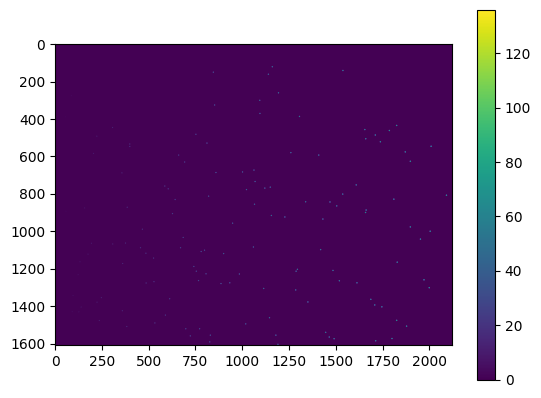

In [20]:
#plt.imshow(mask[835:845,380:390])
plt.imshow(mask)
plt.colorbar()


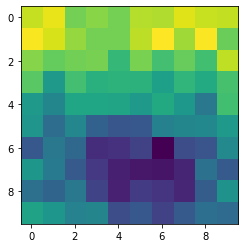

In [40]:
plt.imshow(jpg[835:845,380:390, 1])


# Individual (non-centered) cluster images

In [10]:

def freq_stamper(ras, decs):
    comm = MPI.COMM_WORLD
    myrank = comm.Get_rank()
    nproc = comm.Get_size()
    freqs = ["090", "150", "220"]

    dr = 30*u.arcmin
    
    for i in range(myrank, len(ras), nproc):
        print(i, end="\r")
        offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
        ra_cent = ras[i]*u.deg+offset_ra
        dec_cent = decs[i]*u.deg+offset_dec

        ra_min, ra_max = ra_cent - dr, ra_cent + dr
        dec_min, dec_max = dec_cent - dr, dec_cent + dr
    
        if ra_max < ra_min:
            ra_min -= 360
        
        box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
    
        #Make jpg of box
        #jpg, cur_wcs = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)
        stamp, cur_wcs = make_stamp('/mnt/welch/USERS/jorlo/maps/20240323_simple/act_planck_*_f*_daynight_map_srcfree.fits', box, freqs, normalize = False)
        print(cur_wcs)
        if type(stamp) == int: continue
    
        #np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}".format(str(i).zfill(4)), jpg)
        enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}.fits".format(str(i).zfill(4)), stamp)
        mask = make_mask(stamp, act_catalog, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
        #print(mask.shape)
        np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_masks/{}_mask".format(str(i).zfill(4)), mask)
    
        

with ipp.Cluster(controller_ip="*", engines="mpi", n=24) as rc:
    view = rc.broadcast_view()
    r = view.apply_sync(freq_stamper(ras, decs))
    print("\n".join(r))

Starting 24 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/24 [00:00<?, ?engine/s]

car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[53.00,4690.50]}
54.0 54.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[43.00,4806.50]}
51.0 53.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[49.00,5331.50]}
56.0 56.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[49.00,-1156.50]}
60.0 56.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[46.00,2695.50]}
56.0 51.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[47.00,-1759.50]}
59.0 51.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[44.00,179.50]}
56.0 53.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[42.00,3424.50]}
53.0 52.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[30.00,-230.50]}
51.0 59.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[33.00,696.50]}
55.0 51.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[37.00,5592.50]}
58.0 57.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[24.00,917.50]}
51.0 51.0
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[23.00,6996.50]}
52.0 58.0
car:{cdelt:[0

KeyboardInterrupt: 

In [4]:
img = fits.open("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}.fits".format(str(i).zfill(4)))
img = np.array(img[0].data).transpose(1,2,0)

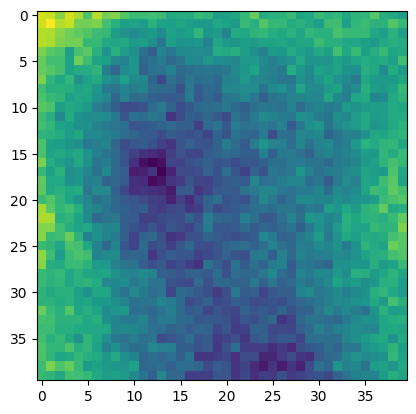

In [18]:
i = 2000
stamp = enmap.read_map("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}.fits".format(str(i).zfill(4)))
plt.imshow(stamp[1])

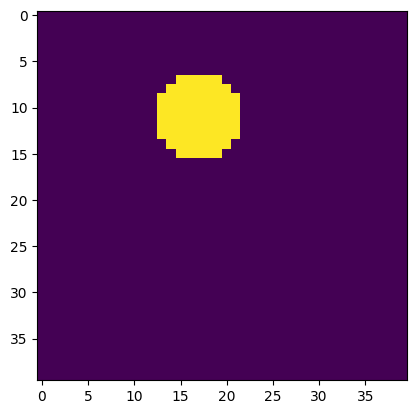

In [66]:
plt.imshow(mask)

# Websky Cluster Stamps

In [4]:
websky_catalog = fits.open('/mnt/welch/USERS/jorlo/ml-clusters/ACTSim_CMB-T_cmb-tsz_MFMF_pass2_mass.fits')

ras, decs = np.array(websky_catalog[1].data['RADeg']), np.array(websky_catalog[1].data['decDeg'])

In [5]:
def freq_stamper(ras, decs):
    comm = MPI.COMM_WORLD
    myrank = comm.Get_rank()
    nproc = comm.Get_size()
    freqs = ["090", "150", "220"]

    dr = 60*u.arcmin
    
    for i in range(myrank, len(ras), nproc):
        print(i, end="\r")
        offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
        ra_cent = ras[i]*u.deg+offset_ra
        dec_cent = decs[i]*u.deg+offset_dec

        ra_min, ra_max = ra_cent - dr, ra_cent + dr
        dec_min, dec_max = dec_cent - dr, dec_cent + dr
    
        if ra_max < ra_min:
            ra_min -= 360
        
        box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
    
        #Make jpg of box
        stamp, cur_wcs, = make_stamp("/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits", box, freqs, normalize = False)
        if type(stamp) == int: continue
    
        enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_stamps/{}.fits".format(str(i).zfill(5)), stamp)
        #mask = make_mask(stamp, ras, decs, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
        mask = make_mask(stamp, ras, decs, box, cur_wcs, size = 4.8)

        #print(mask.shape)
        np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_masks/{}_mask".format(str(i).zfill(5)), mask)
    
        

with ipp.Cluster(controller_ip="*", engines="mpi", n=24) as rc:
    view = rc.broadcast_view()
    r = view.apply_sync(freq_stamper(ras, decs))
    #print("\n".join(r))

Starting 24 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/24 [00:00<?, ?engine/s]

Stopping engine(s): 1722445935
Output for ipengine-1722445934-oqlw-1722445935-238465:
2024-07-31 13:12:16.984 [IPEngine.15] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-07-31 13:12:16.984 [IPEngine.3] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-07-31 13:12:16.984 [IPEngine.15] Completed registration with id 15
2024-07-31 13:12:16.984 [IPEngine.3] Completed registration with id 3
2024-07-31 13:12:16.984 [IPEngine.1] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-07-31 13:12:16.984 [IPEngine.0] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-07-31 13:12:16.984 [IPEngine.19] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-07-31 13:12:16.984 [IPEngine.4] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.

TypeError: make_stamp() missing 2 required positional arguments: 'ra' and 'dec'

In [37]:
imap = enmap.read_map("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_stamps/01000.fits")
with np.load("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_masks/01000_mask.npz") as data:
    mask = data['arr_0']
mask = np.array(mask, dtype='f')


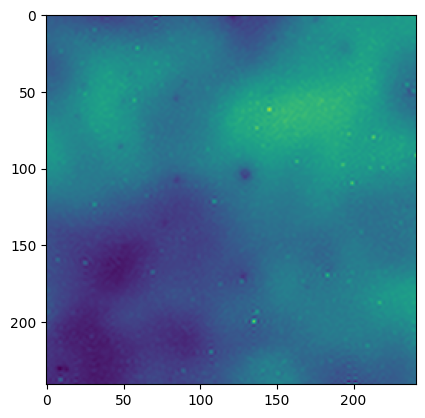

In [39]:
plt.imshow(imap[0])

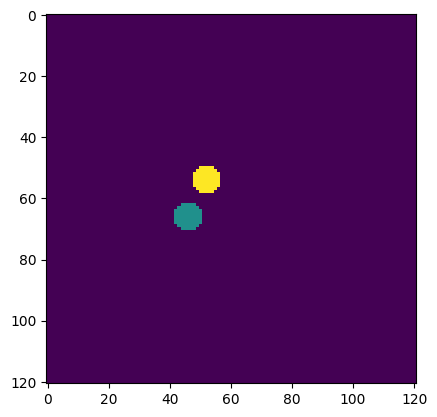

In [99]:
plt.imshow(mask)

In [6]:
freqs = ["090", "150", "220"]
idx = np.where((websky_catalog[1].data["M200m"] == np.amax(websky_catalog[1].data["M200m"])))[0]
dr = 30*u.arcmin
i = idx[0]
#i = 193
offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
ra_cent = ras[i]*u.deg+offset_ra
dec_cent = decs[i]*u.deg+offset_dec

ra_min, ra_max = ra_cent - dr, ra_cent + dr
dec_min, dec_max = dec_cent - dr, dec_cent + dr

if ra_max < ra_min:
    ra_min -= 360

box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
#Make jpg of box
stamp, cur_wcs = make_stamp("/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits", box, freqs, normalize = False, reproj=False)

enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_stamps/{}.fits".format(str(i).zfill(5)), stamp)
#mask = make_mask(stamp, ras, decs, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
mask = make_mask(stamp, ras, decs, box, cur_wcs, size = 4.8)

TypeError: make_stamp() missing 2 required positional arguments: 'ra' and 'dec'

In [31]:
#min_ra, max_ra, min_dec, max_dec = 221.89426093124743, 222.89426093124743, -3.5972671920543204, -2.59726719205432
in_image = np.where((ra_min.value < ras) & (ras < ra_max.value) & (dec_min.value < decs) & (decs < dec_max.value))[0]
xs, ys = np.zeros(len(in_image)), np.zeros(len(in_image))
for i in range(len(in_image)):
    cur_cluster = in_image[i]
    cur_center = SkyCoord(ras[cur_cluster], decs[cur_cluster], unit = "deg")
    x,y = wcs.utils.skycoord_to_pixel(cur_center, cur_wcs)
    xs[i] = x; ys[i] = y
print(xs, ys)

[52.65112445 59.05925503] [71.41383553 58.95330606]


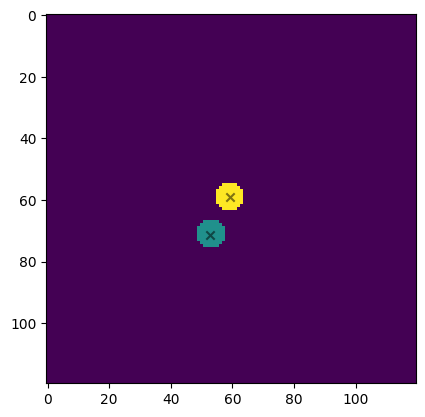

In [32]:
plt.imshow(mask)
plt.scatter(xs, ys, color="black", alpha = 0.5, marker="x")

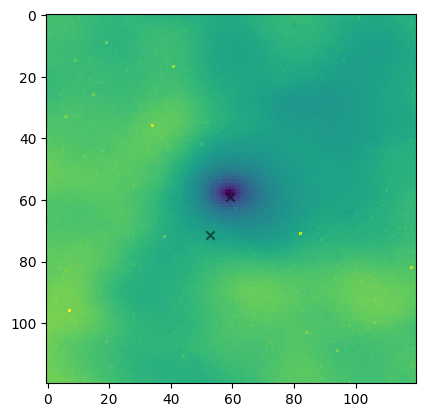

In [33]:
plt.imshow(stamp[1])
#plt.scatter(xs+7, ys, color="black", alpha = 0.5, marker="x")
plt.scatter(xs, ys, color="black", alpha = 0.5, marker="x")

In [20]:
freqs = ["090", "150", "220"]
idx = np.where((websky_catalog[1].data["M200m"] == np.amax(websky_catalog[1].data["M200m"])))[0]
dr = 30*u.arcmin
i = idx[0]
#i = 193

offset = 0
offset_ra, offset_dec = np.random.uniform(-1,1)*offset*u.arcmin, np.random.uniform(-1,1)*offset*u.arcmin
ra_cent = ras[i]*u.deg+offset_ra
dec_cent = decs[i]*u.deg+offset_dec

ra_min, ra_max = ra_cent - dr, ra_cent + dr
dec_min, dec_max = dec_cent - dr, dec_cent + dr

if ra_max < ra_min:
    ra_min -= 360

box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
#Make jpg of box
stamp, cur_wcs = make_stamp("/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits", box, freqs, 
                            offset_ra.value * utils.arcmin, offset_dec.value * utils.arcmin, normalize = False, reproj=False)

enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/websky_tiles/cluster_stamps/{}.fits".format(str(i).zfill(5)), stamp)
#mask = make_mask(stamp, ras, decs, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
mask = make_mask(stamp, ras, decs, box, cur_wcs, size = 4.8)
#min_ra, max_ra, min_dec, max_dec = 221.89426093124743, 222.89426093124743, -3.5972671920543204, -2.59726719205432
in_image = np.where((ra_min.value < ras) & (ras < ra_max.value) & (dec_min.value < decs) & (decs < dec_max.value))[0]
xs, ys = np.zeros(len(in_image)), np.zeros(len(in_image))
for i in range(len(in_image)):
    cur_cluster = in_image[i]
    cur_center = SkyCoord(ras[cur_cluster], decs[cur_cluster], unit = "deg")
    x,y = wcs.utils.skycoord_to_pixel(cur_center, cur_wcs)
    xs[i] = x; ys[i] = y
print(xs, ys)

[53.65112445 60.05925503] [72.41383553 59.95330606]


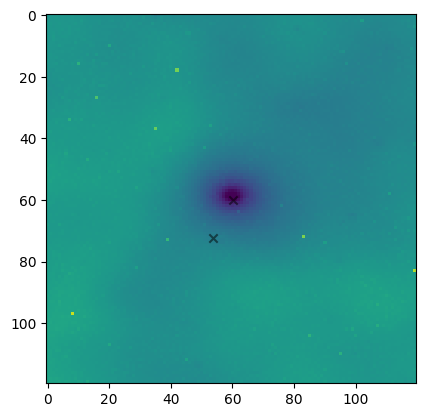

In [21]:
plt.imshow(stamp[0], vmin = -1e3, vmax=1e3)
plt.scatter(xs, ys, color="black", alpha = 0.5, marker="x")

# Websky Full Catalog

In [4]:
path = "/mnt/welch/USERS/cwhitaker/maps/websky/"
cluster_catalog=open(path + 'halos.pksc')
N = np.fromfile(cluster_catalog,count=3,dtype=np.int32)[0]
catalog=np.fromfile(cluster_catalog,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

In [5]:
from scipy.interpolate import *
import healpy as hp

omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [6]:
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M        = 4*np.pi/3.*rho*R**3        # Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)
DEC, RA  = hp.vec2ang(np.column_stack((x,y,z)),lonlat=True)

# convert to ra / dec (radians) from readhalos.py
colat, cluster_ras = hp.vec2ang(np.column_stack((x, y, z)))

# convert colat to dec 
cluster_decs = np.pi/2 - colat

In [14]:
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo

ap = 0.12
h70 = cosmo.H0.value / 7.00e01

Tcmb = 2.7255
kb = const.k_B.value
me = ((const.m_e * const.c**2).to(u.keV)).value
h = const.h.value
Xthom = const.sigma_T.to(u.cm**2).value

Mparsec = u.Mpc.to(u.cm)
XMpc = Xthom * Mparsec

rad_to_arcsec = (180 * 3600) / np.pi

# Cosmology
# --------------------------------------------------------
dzline = np.linspace(0.00, 5.00, 1000)
daline = cosmo.angular_diameter_distance(dzline) / u.radian
nzline = cosmo.critical_density(dzline)
hzline = cosmo.H(dzline) / cosmo.H0

daline = daline.to(u.Mpc / u.arcsec)
nzline = nzline.to(u.Msun / u.Mpc**3)

dzline = np.array(dzline)
hzline = np.array(hzline.value)
nzline = np.array(nzline.value)
daline = np.array(daline.value)

def get_da(z):
    return np.interp(z, dzline, daline)

In [9]:

R

array([27.497486 , 27.441055 , 27.33656  , ...,  1.9797994,  1.9797983,
        1.9797931], dtype=float32)

In [17]:
get_da(redshift)

array([0.00411296, 0.00249861, 0.00495165, ..., 0.00837922, 0.00837955,
       0.0083796 ])

In [20]:
r_arcmin = R / get_da(redshift) / 60

In [22]:
ras, decs = cluster_ras, cluster_decs

In [26]:
freqs = ["090", "150", "220"]
#idx = np.where((websky_catalog[1].data["M200m"] == np.amax(websky_catalog[1].data["M200m"])))[0]
dr = 30*u.arcmin
#i = idx[0]
i = 0
offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
ra_cent = ras[i]*u.deg+offset_ra
dec_cent = decs[i]*u.deg+offset_dec

ra_min, ra_max = ra_cent - dr, ra_cent + dr
dec_min, dec_max = dec_cent - dr, dec_cent + dr

if ra_max < ra_min:
    ra_min -= 360

box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
#Make jpg of box
stamp, cur_wcs = make_stamp("/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits", box, freqs, normalize = False, reproj=False)

#mask = make_mask(stamp, ras, decs, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
mask = make_mask(stamp, ras, decs, box, cur_wcs, size = 4.8)

KeyboardInterrupt: 

# Cluster Centered Stamps for Backbone training

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs, act_sn = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg'], act_catalog[1].data['SNR']


In [22]:
size = 2.5

offset = 2.0

to_return_90 = []
randoms_90 = []
map_path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('090'))[0]

offsets = []

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra_off, dec_off = np.random.rand(2)*offset*u.arcmin
    offsets.append([ra_off, dec_off])
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg 

    ra += offsets[i][0]
    dec += offsets[i][1]
    
    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_90.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    ra -= offsets[i][0]
    dec -= offsets[i][1]
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_90.append(rand_stamp)
    
to_return_90 = np.stack(to_return_90, axis=0)
randoms_90 = np.stack(randoms_90, axis=0)

to_return_150 = []
randoms_150 = []

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('150'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    ra += offsets[i][0]
    dec += offsets[i][1]
    
    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_150.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_150.append(rand_stamp)
    
to_return_150 = np.stack(to_return_150, axis=0)
randoms_150 = np.stack(randoms_150, axis=0)

to_return_220 = []
randoms_220 = []

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('220'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    
    
    
    ra += offsets[i][0]
    dec += offsets[i][1]

    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_220.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_220.append(rand_stamp)
    
to_return_220 = np.stack(to_return_220, axis=0)
randoms_220 = np.stack(randoms_220, axis=0)

In [23]:
to_return = np.stack([to_return_90, to_return_150, to_return_220], axis = -1)
randoms = np.stack([randoms_90, randoms_150, randoms_220], axis = -1)

In [24]:
to_return.shape

(4195, 41, 41, 3)

In [25]:
randoms.shape

(4195, 41, 41, 3)

In [26]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_freq_stamps/all_clusters_offset.npz', to_return)
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_freq_stamps/randoms.npz', randoms)

In [27]:
offsets

[[<Quantity 1.77377797 arcmin>, <Quantity 1.31512559 arcmin>],
 [<Quantity 1.42211724 arcmin>, <Quantity 1.85129277 arcmin>],
 [<Quantity 0.92705887 arcmin>, <Quantity 1.0624802 arcmin>],
 [<Quantity 0.8689888 arcmin>, <Quantity 0.20484821 arcmin>],
 [<Quantity 1.98746077 arcmin>, <Quantity 1.77077256 arcmin>],
 [<Quantity 1.41275386 arcmin>, <Quantity 0.69555906 arcmin>],
 [<Quantity 0.52207623 arcmin>, <Quantity 0.17776005 arcmin>],
 [<Quantity 1.60976142 arcmin>, <Quantity 1.73016798 arcmin>],
 [<Quantity 1.52529009 arcmin>, <Quantity 0.64914156 arcmin>],
 [<Quantity 1.66635367 arcmin>, <Quantity 0.85762957 arcmin>],
 [<Quantity 1.51165244 arcmin>, <Quantity 1.27269585 arcmin>],
 [<Quantity 1.31106619 arcmin>, <Quantity 1.2679472 arcmin>],
 [<Quantity 0.46878351 arcmin>, <Quantity 0.16954994 arcmin>],
 [<Quantity 0.71286321 arcmin>, <Quantity 0.51696604 arcmin>],
 [<Quantity 1.81504139 arcmin>, <Quantity 1.08281158 arcmin>],
 [<Quantity 1.2960502 arcmin>, <Quantity 1.99854195 arcmin

In [26]:
stack = 0
n = 0

for i in range(to_return.shape[0]):
    weight = act_sn[i]
    stack += to_return[i,...,0]*weight
    n += weight

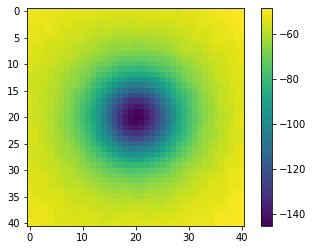

In [27]:
plt.imshow(stack/n)
plt.colorbar()
plt.show()
plt.close()

# Single Cluster y stamps

In [5]:
path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

ymap = enmap.read_map(path + 'stitched_Arnaud_M2e14_z0p4_filteredMap.fits')

In [6]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

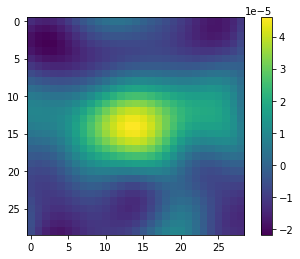

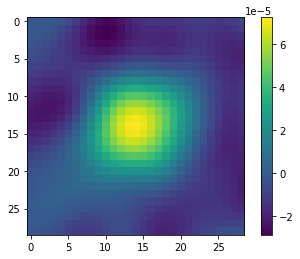

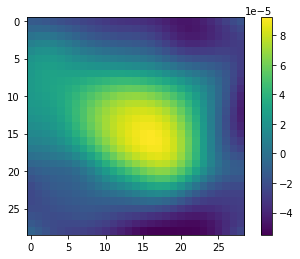

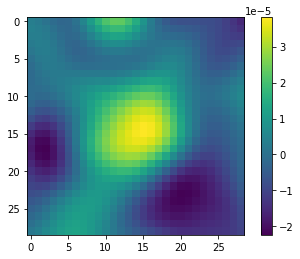

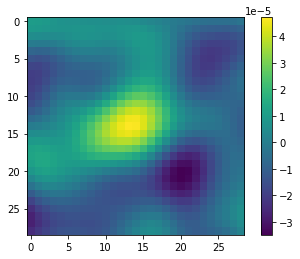

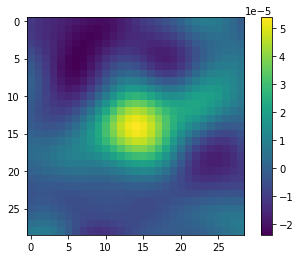

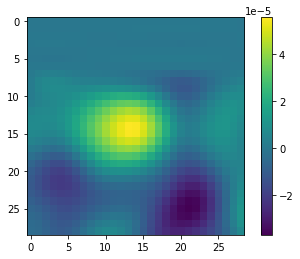

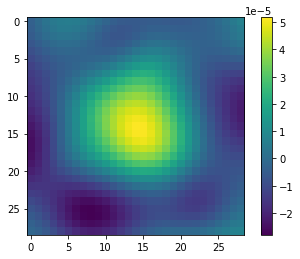

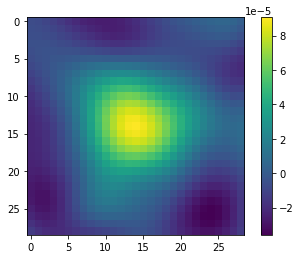

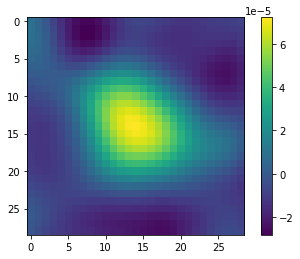

In [13]:
to_return_y = []

for i in range(10):
    width = 3.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    plt.imshow(stamp)
    plt.colorbar()
    plt.show()
    plt.close()
    #stamp = normalize_map(stamp)

    to_return_y.append(stamp)
to_return_y = np.stack(to_return_y, axis=0)
to_return_y/= np.amax(to_return_y)
pk.dump(to_return_y, open('/project/r/rbond/jorlo/datasets/act_y_stamps/test_clusters.pk', 'wb'))

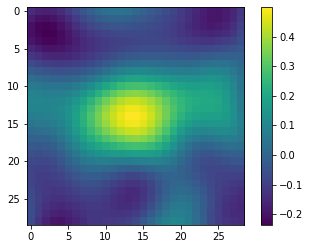

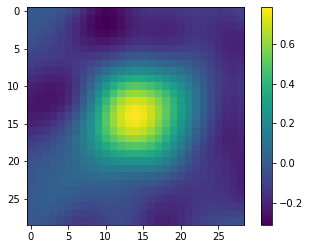

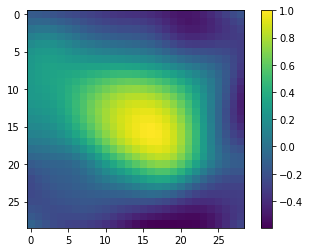

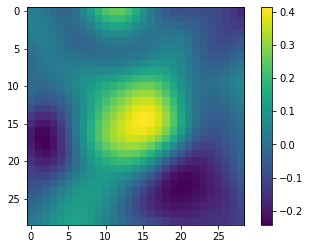

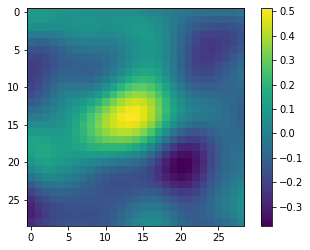

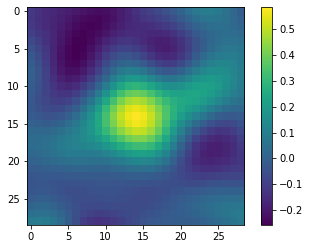

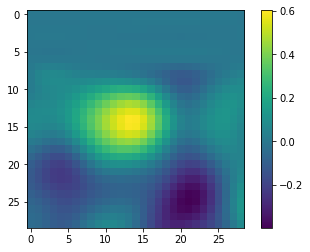

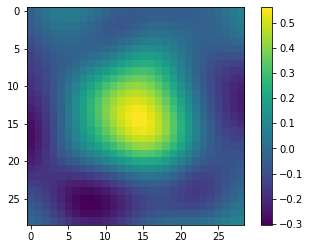

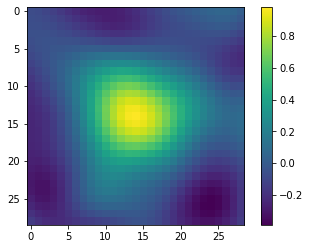

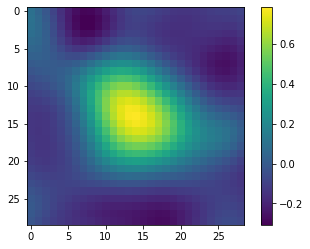

In [14]:
for i in range(10):
    plt.imshow(to_return_y[i,...])
    plt.colorbar()
    plt.show()
    plt.close()

In [24]:
to_return_y = []

for i, name in enumerate(act_catalog[1].data['name']):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_y.append(stamp)

to_return_y = np.stack(to_return_y, axis=0)

In [25]:
to_return_y/= np.amax(to_return_y)

In [26]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/all_clusters.npz', to_return_y)

# ILC Compton-y

In [44]:
path = '/project/r/rbond/msyriac/ilc_dr6v3/20220224/'

ymap = enmap.read_map(path + 'ilc_SZ_yy.fits')
mask = enmap.read_map(path + 'wide_mask_GAL080_apod_3.00_deg.fits')

In [45]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

In [46]:
to_return_y = []

for i , name in enumerate(act_catalog[1].data['name']):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    
    mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    if np.any(mask_stamp < 1): continue
    
    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
   
    to_return_y.append(stamp)

to_return_y = np.stack(to_return_y, axis=0)

In [47]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/ilc_all_clusters.npz', to_return_y)

## ILC Randoms

In [48]:
path = '/project/r/rbond/msyriac/ilc_dr6v3/20220224/'

ymap = enmap.read_map(path + 'ilc_SZ_yy.fits')
mask = enmap.read_map(path + 'wide_mask_GAL080_apod_3.00_deg.fits')

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

In [66]:
to_return_randoms = []

i = 0 

for i in range(len(ras)):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg
    
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    if mask_stamp.at([0,0])< 0.99: continue
    '''
    while np.any(mask_stamp < 0.9):
        if mask_stamp.at([0,0])< 0.8: break
        ra, dec = ras[i]*u.deg, decs[i]*u.deg
    
        theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
        ra += np.cos(theta)*dr*u.arcmin
        dec += np.sin(theta)*dr*u.arcmin

        mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                            apod = 2*utils.arcmin)
    '''
    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
   
    to_return_randoms.append(stamp)

to_return_randoms = np.stack(to_return_randoms, axis=0)


In [67]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/ilc_randoms.npz', to_return_randoms)

In [68]:
to_return_randoms.shape

(3875, 37, 37)

In [69]:
to_return_y.shape

(3474, 37, 37)

In [5]:
#Paths to a couple coadded maps

#path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'
#path = '/project/r/rbond/jorlo/stitched_Beam_filteredMap.fits'
freqs = ['220', '150', '090']

#Unused code for taking a look at the maps
#cur_map = enmap.read_map(path + 'act_planck_s08_s19_cmb_f{}_night_map.fits'.format(freqs[2]))
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]))

cur_map = cur_map[0]

#plots = enplot.plot(cur_map,range=300,mask=0)
#enplot.write("plots_example",plots)

#def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
#enplot.show(enplot.plot(cur_map))

In [6]:
cur_map.wcs

In [11]:
from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [11]:
hdu.header

In [12]:
plt.imshow(cur_map[0], vmin = -300, vmax = 300)

In [26]:

#Create a box
ra_min = 0; ra_max = 10; dec_min=0; dec_max=10
box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
box = [[-1.0645054,   0.94960714], [-0.93651459,  1.25052841]]
print(box)
#Make jpg of box
jpg = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)

#The image package allows us to turn the array into a jpg for saving
im = Image.fromarray(jpg, 'RGB')
im.save("test_jpg.jpeg")

In [27]:
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box = box)

cur_map = cur_map[0]

from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [25]:
jpg.shape

In [14]:
plt.imshow(jpg[...,2])
plt.colorbar()

In [15]:
np.amax(jpg[...,2])

In [11]:
for i in range(0, 360, 10):
    ra_min = i; ra_max = i+10
    dec_min = 0; dec_max = 10
    #TODO: Galaxy masking
    box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
    cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box=box)
    plt.imshow(cur_map[0], vmin=-300, vmax = 300)
    plt.show()
    plt.close()

In [6]:
plt.imshow(cur_map[0], vmin=-300, vmax = 300)

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

actRa = act_catalog[1].data['RADeg']
actNames = act_catalog[1].data['name']
actDec = act_catalog[1].data['decDeg']
actRa, actDec = np.array(actRa), np.array(actDec)
actSnr = act_catalog[1].data['fixed_SNR']
actz = act_catalog[1].data['redshift']

In [13]:
#path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

#tileName = tileFinder(actRa[0], actDec[0], s18d)
#tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
ra, dec = actRa[0]*u.deg, actDec[0]*u.deg
stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=5*utils.arcmin,
                            apod = 2*utils.arcmin)#5.*np.pi/(60*180))
#plot = enplot.plot(stamp)
#enplot.show(plot)

In [17]:
plt.imshow(stamp[0])
print(stamp.shape)
plt.colorbar()

In [31]:
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2)
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2*(3600 * 180)/np.pi)
print(0.004167*(60 * 180)/np.pi)

In [32]:
print(10/41*60)

In [33]:
print(cur_map.wcs.wcs.cdelt)
print(stamp.wcs.wcs.cdelt)

In [34]:
ra, dec = actRa[0], actDec[0]
stamp1 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp1)
print(stamp.shape)

In [ ]:
stamp2 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp2)
print(stamp.shape)

In [ ]:
plt.imshow((stamp1-stamp2)/stamp1)
plt.colorbar()



In [ ]:
stamp = 0
for i in range(len(actRa)):
    ra, dec = actRa[i]*u.deg, actDec[i]*u.deg
    full_box  = reproject.thumbnails(cur_map, (dec.to(u.radian).value, ra.to(u.radian).value), r=20.*np.pi/(60*180))
    stamp+=full_box

In [ ]:
plt.imshow(stamp)

In [ ]:
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'

freq_map_090 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f090_night_map.fits')
freq_map_150 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f150_night_map.fits')
freq_map_220 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f220_night_map.fits')

temp = cutout(actRa[:2], actDec[:2], freq_map_090, freq_map_150, freq_map_220, scale = 10)

# WISE Stamping

In [3]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ras, decs, zs = np.array(act_catalog[1].data['RADeg']), np.array(act_catalog[1].data['decDeg']), np.array(act_catalog[1].data['redshift'])

c = SkyCoord(ras[500], decs[500], unit="deg")
paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 5*u.arcmin)

In [ ]:
z_cut = 0.

for i in range(len(ras)):
    print(i, end = '\r')
    if zs[i] < z_cut: continue
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4))):
        continue
    try:
        c = SkyCoord(ras[i], decs[i], unit="deg")
        paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 5*u.arcmin)
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4)), to_return)
    
    mask = make_mask_wise(paths[0][0].data, [150, 150], radius*2/300, size = 4.8)

    #print(mask.shape)
    np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/{}_mask".format(str(i).zfill(4)), mask)

In [ ]:
for i in range(len(ras)):
    print(i, end = '\r')
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/randoms_{}.npz'.format(str(i).zfill(4))):
        continue
        
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra, dec = ras[i]*u.deg+np.cos(theta)*dr*u.arcmin, decs[i]*u.deg+np.sin(theta)*dr*u.arcmin
    c = SkyCoord(ra, dec)

    try:
        paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 7*u.arcmin)
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/randoms_{}.npz'.format(str(i).zfill(4)), to_return)

In [32]:
z_cut = 0.
radius = 7

for i in range(len(ras)):
    print(i, end = '\r')
    if zs[i] < z_cut: continue
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4))):
        continue
    try:
    offset_ra, offset_dec = np.random.rand()*2.5/60, np.random.rand()*2.5/60


    c = SkyCoord(ras[i]+offset_ra, decs[i]+offset_dec, unit="deg")
    paths = SkyView.get_images(position=c,
                               survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                              radius = radius*u.arcmin)
    
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_offset_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4)), to_return)
    mask = make_mask_wise(paths[0][0].data, [150+(offset_ra*60/(2*radius)*300), 150+(offset_dec*60/(2*radius)*300)], radius*2/300, size = 4.8)
    np.savez_compressed("/project/r/rbond/jorlo/datasets/act_offset_wise_stamps/masks/{}_mask".format(str(i).zfill(4)), mask)

-0.016666666666666666


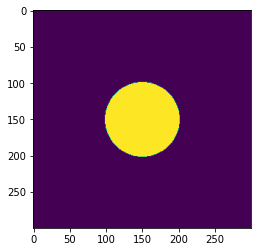

In [44]:
plt.imshow(mask)

In [43]:
c = SkyCoord(ras[500], decs[500], unit="deg")
paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = radius*u.arcmin)

mask = make_mask_wise(paths[0][0].data, [150, 150], radius*2/300, size = 4.8)
np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/cluster_mask_{}".format(str(i).zfill(4)), mask)

In [45]:
for i, dirname in enumerate(os.listdir('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/')):
    if dirname[0] == 'c':
        np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/cluster_mask_{}".format(dirname[8:12]), mask)
